In [10]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import accuracy_score

In [5]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',index_col=0, parse_dates=True).dropna()
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [6]:
symbol = 'GLD'
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: 'price'}, inplace=True)
data['return'] = np.log(data['price'] / data['price'].shift(1))
data.dropna(inplace=True)

In [8]:
lags = 3
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data['return'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

In [11]:
# Instantiates the model object using a C value that gives less weight to the regularization term (see the Generalized Linear Models page).
lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',multi_class='auto',max_iter=1000)

# Fits the model based on the sign of the returns to be predicted.
lm.fit(data[cols], np.sign(data['return']))

# Generates a new column in the DataFrame object and writes the prediction values to it.
data['prediction'] = lm.predict(data[cols])

# Shows the number of the resulting long and short positions, respectively.
data['prediction'].value_counts()

/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


prediction
 1.0    1975
-1.0     537
Name: count, dtype: int64

In [12]:
hits = np.sign(data['return'].iloc[lags:] *data['prediction'].iloc[lags:]).value_counts()
hits

 1.0    1344
-1.0    1153
 0.0      12
Name: count, dtype: int64

In [13]:
# The accuracy (hit ratio) is 53.3% in this case.
accuracy_score(data['prediction'],np.sign(data['return']))

0.5362261146496815

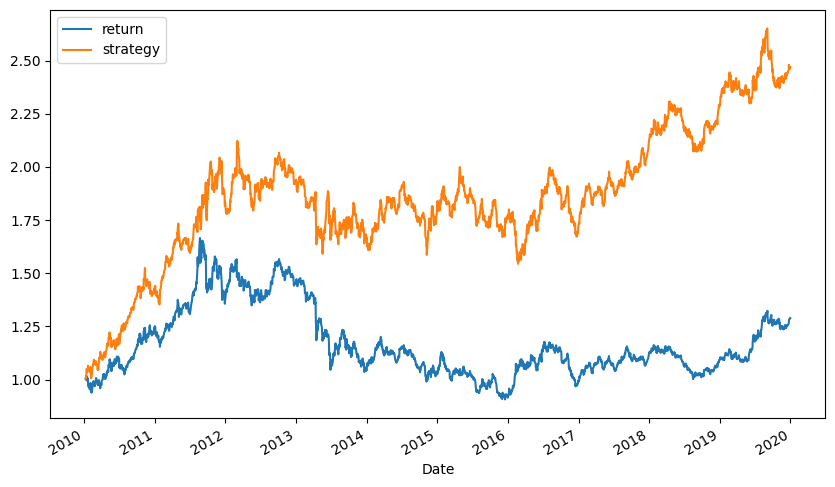

In [15]:
data['strategy'] = data['prediction'] * data['return']
data[['return', 'strategy']].sum().apply(np.exp)
data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

Logistic regression improves the hit ratio compared to linear regression by more than a percentage point to about 54.5%. Figure 5-13 shows the performance of the strategy based on logistic regression-based predictions. Although the hit ratio is higher, the performance is worse than with linear regression.

Increasing the number of lags used from three to five decreases the hit ratio but improves the gross performance of the strategy to some extent (in-sample, before transaction costs). Figure 5-14 shows the resulting performance:

In [17]:
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: 'price'}, inplace=True)
data['return'] = np.log(data['price'] / data['price'].shift(1))
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_%d' % lag
    data[col] = data['price'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

In [18]:

lm.fit(data[cols], np.sign(data['return']))
data['prediction'] = lm.predict(data[cols])
data['prediction'].value_counts()

/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


prediction
 1.0    2042
-1.0     469
Name: count, dtype: int64

In [20]:
hits = np.sign(data['return'].iloc[lags:] *data['prediction'].iloc[lags:]).value_counts()
hits

 1.0    1332
-1.0    1162
 0.0      12
Name: count, dtype: int64

In [21]:
accuracy_score(data['prediction'],np.sign(data['return']))

0.5316606929510155

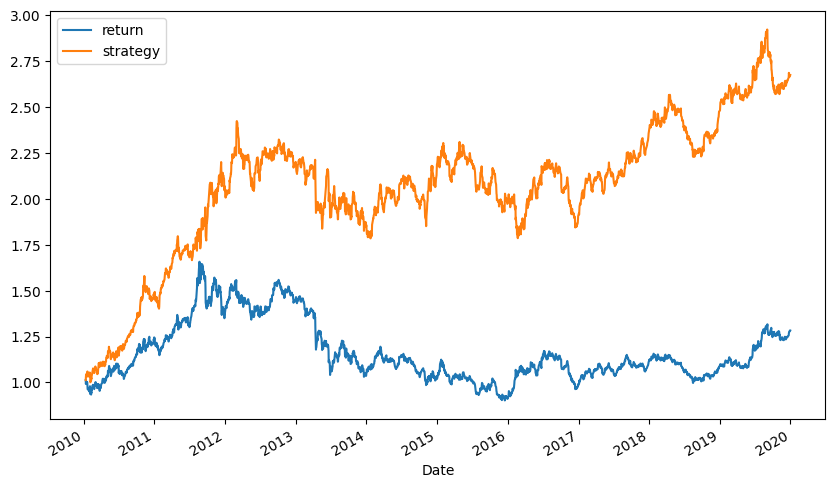

In [22]:
data['strategy'] = data['prediction'] * data['return']
data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

You have to be careful to not fall into the overfitting trap here. A more realistic picture is obtained by an approach that uses training data (= in-sample data) for the fitting of the model and test data (= out-of-sample data) for the evaluation of the strategy performance. This is done in the following section, when the approach is generalized again in the form of a Python class.

## Generalizing the Approach

In [23]:
import logistic_reg_backtester as LgR

In [24]:
scibt = LgR.ScikitVectorBacktester('EUR=','2010-1-1', '2019-12-31',10000, 0.0, 'logistic')

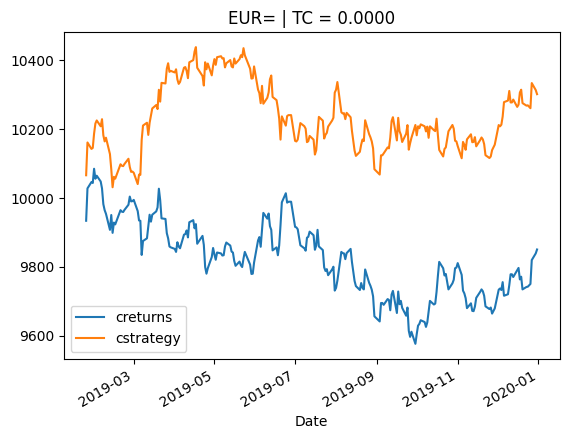

In [25]:
scibt.run_strategy('2015-1-1', '2019-12-31','2015-1-1', '2019-12-31', lags=15)
scibt.run_strategy('2016-1-1', '2018-12-31','2019-1-1', '2019-12-31', lags=15)
scibt.plot_results()

Gross performance of S&P 500 and the out-of-sample logistic regression-based strategy (15 lags, no transaction costs)

As another example, consider the same strategy applied to the GDX ETF, for which an out-of-sample outperformance (over the year 2018) is shown in Figure 5-16 (before transaction costs):

In [26]:
scibt = LgR.ScikitVectorBacktester('GDX','2010-1-1', '2019-12-31',10000, 0.00, 'logistic')

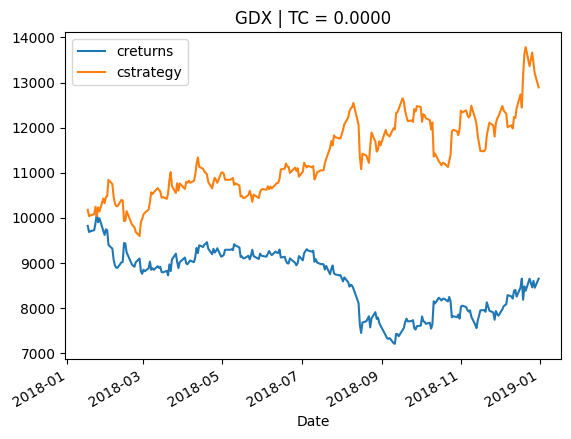

In [27]:
scibt.run_strategy('2013-1-1', '2017-12-31','2018-1-1', '2018-12-31', lags=10)
scibt.plot_results()

Gross performance of GDX ETF and the logistic regression-based strategy (10 lags, out-of-sample, no transaction costs). 

The next figure shows how the gross performance is diminished—leading even to a net
loss—when taking transaction costs into account, while keeping all other parameters
constant:


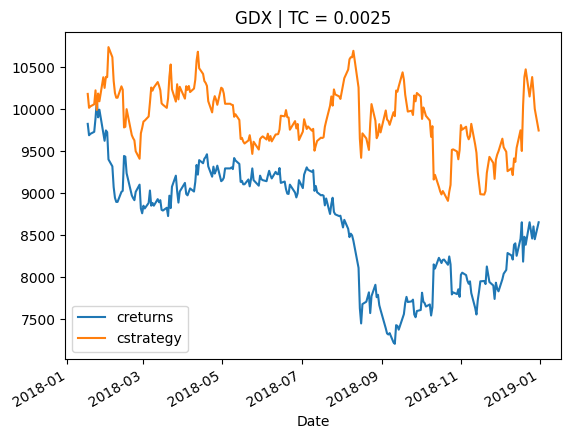

In [29]:
scibt = LgR.ScikitVectorBacktester('GDX','2010-1-1', '2019-12-31',10000, 0.0025, 'logistic')
scibt.run_strategy('2013-1-1', '2017-12-31','2018-1-1', '2018-12-31', lags=10)
scibt.plot_results()
